In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from utils import scatter_plot
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Import Dataset

In [16]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [17]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [18]:
X_train['drain_area_va'] = np.log10(X_train['drain_area_va'])
X_train['q_va'] = np.log10(X_train['q_va'])
X_train['stream_wdth_va'] = np.log10(X_train['stream_wdth_va'])
X_train['xsec_area_va'] = np.log10(X_train['xsec_area_va'])
y_train= np.log10(y_train)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train).astype('float32')

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).astype('float32').ravel()

X_test['drain_area_va'] = np.log10(X_test['drain_area_va'])
X_test['q_va'] = np.log10(X_test['q_va'])
X_test['stream_wdth_va'] = np.log10(X_test['stream_wdth_va'])
X_test['xsec_area_va'] = np.log10(X_test['xsec_area_va'])

X_test = X_scaler.transform(X_test).astype('float32')

In [19]:
## Model
mlp = MLPRegressor(max_iter=100)
param_grid = {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['logistic', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            }

mlp_grid = GridSearchCV(mlp, param_grid, cv=8, n_jobs=30, verbose=3)
mlp_grid.fit(X_train, y_train)

Fitting 8 folds for each of 48 candidates, totalling 384 fits


GridSearchCV(cv=8, estimator=MLPRegressor(max_iter=100), n_jobs=30,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=3)

In [20]:
print(mlp_grid.best_params_)
print(mlp_grid.best_score_)

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.9981214767383462


In [24]:
import pickle

with open('./data/ml_weights/mlp_best_model', "wb") as fp:
    pickle.dump(mlp_grid.best_estimator_, fp)

In [4]:
import pickle

with open('./data/ml_weights/mlp_best_model', "rb") as fp:
    mlp_grid = pickle.load(fp)

NSE: 0.9882, R2: 0.9882, PBias: -0.0287, MSE: 0.6698


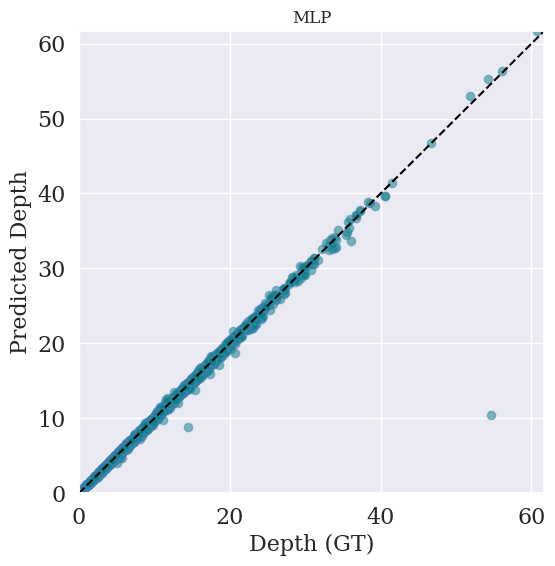

In [21]:
y_pred = mlp_grid.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_pred = 10 ** y_pred
scatter_plot(y_test, y_pred, model_name='MLP')

In [22]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(mlp_grid, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

index=['drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va']
mlp_importances = pd.Series(result.importances_mean, index=index)

Elapsed time to compute the importances: 2.097 seconds


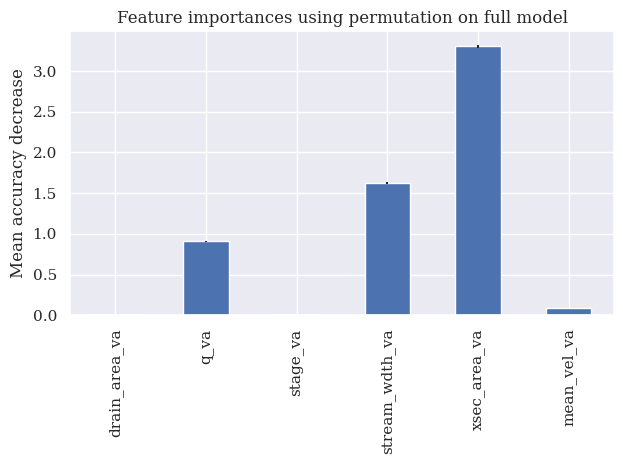

In [23]:
fig, ax = plt.subplots()
mlp_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()